In [3]:
# Tạ Cao Sơn - B22DCVT445

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Load dữ liệu
df = pd.read_csv('generate-data/case3/diabetes.csv')

print("Thông tin dataset:")
print(f"Kích thước: {df.shape}")
print(f"\nCác cột: {df.columns.tolist()}")
print(f"\nThông tin dữ liệu:")
print(df.info())
print(f"\nThống kê mô tả:")
print(df.describe())
print(f"\nSố lượng giá trị thiếu:")
print(df.isnull().sum())
print(f"\nPhân bổ Outcome:")
print(df['Outcome'].value_counts())
print(f"\nTỷ lệ Outcome:")
print(df['Outcome'].value_counts(normalize=True))

Thông tin dataset:
Kích thước: (768, 9)

Các cột: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Thống kê mô tả:
       Pregnancies     

In [5]:
# Tách features và target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Xử lý giá trị 0 (có thể là missing values) trong một số cột
# Thay thế 0 bằng median cho các cột quan trọng
columns_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in columns_to_fix:
    X[col] = X[col].replace(0, X[col].median())

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"\nPhân bổ y_train: {np.bincount(y_train)}")
print(f"Phân bổ y_test: {np.bincount(y_test)}")

Training set: (614, 8)
Test set: (154, 8)

Phân bổ y_train: [400 214]
Phân bổ y_test: [100  54]


In [6]:
# Model 1: Dense với Dropout (7+ Layers)
def create_model_1(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [7]:
# Model 2: Dense với Batch Normalization (7+ Layers)
def create_model_2(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(8, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Model 3: Dense với Dropout + Batch Normalization (7+ Layers)
def create_model_3(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [8]:
# Hàm compile và train model
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=100):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Chia validation set từ training set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train_final.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (491, 8)
Validation set: (123, 8)
Test set: (154, 8)


In [9]:

# Training Model 1
print("=" * 50)
print("Training Model 1: Dense với Dropout")
print("=" * 50)
model_1 = create_model_1(X_train_final.shape[1])
history_1 = train_model(model_1, X_train_final, y_train_final, X_val, y_val, "Model 1", epochs=100)

Training Model 1: Dense với Dropout
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6436 - loss: 0.6710 - val_accuracy: 0.6504 - val_loss: 0.6258 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6517 - loss: 0.6147 - val_accuracy: 0.6504 - val_loss: 0.5425 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6762 - loss: 0.5613 - val_accuracy: 0.6667 - val_loss: 0.4787 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6823 - loss: 0.5374 - val_accuracy: 0.7886 - val_loss: 0.4597 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7251 - loss: 0.5268 - val_accuracy: 0.8130 - val_loss: 0.4519 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7332 - loss: 0.5156 - val_accuracy: 0.8374 - val_loss: 0.4483 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

In [10]:

# Training Model 2
print("=" * 50)
print("Training Model 2: Dense với Batch Normalization")
print("=" * 50)
model_2 = create_model_2(X_train_final.shape[1])
history_2 = train_model(model_2, X_train_final, y_train_final, X_val, y_val, "Model 2", epochs=100)


Training Model 2: Dense với Batch Normalization
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5112 - loss: 0.7803 - val_accuracy: 0.7642 - val_loss: 0.6784 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6925 - loss: 0.6392 - val_accuracy: 0.7886 - val_loss: 0.6655 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7597 - loss: 0.5737 - val_accuracy: 0.7642 - val_loss: 0.6532 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8004 - loss: 0.5184 - val_accuracy: 0.7398 - val_loss: 0.6390 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8452 - loss: 0.4702 - val_accuracy: 0.7398 - val_loss: 0.6234 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8758 - loss: 0.4224 - val_accuracy: 0.7398 - val_loss: 0.6067 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

In [11]:

# Training Model 3
print("=" * 50)
print("Training Model 3: Dense với Dropout + Batch Normalization")
print("=" * 50)
model_3 = create_model_3(X_train_final.shape[1])
history_3 = train_model(model_3, X_train_final, y_train_final, X_val, y_val, "Model 3", epochs=100)

Training Model 3: Dense với Dropout + Batch Normalization
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5682 - loss: 0.7716 - val_accuracy: 0.6748 - val_loss: 0.6739 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6253 - loss: 0.6555 - val_accuracy: 0.6748 - val_loss: 0.6538 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6884 - loss: 0.6099 - val_accuracy: 0.6667 - val_loss: 0.6281 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7149 - loss: 0.5786 - val_accuracy: 0.6911 - val_loss: 0.6002 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7088 - loss: 0.5741 - val_accuracy: 0.7154 - val_loss: 0.5767 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7413 - loss: 0.5577 - val_accuracy: 0.7480 - val_loss: 0.5588 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━

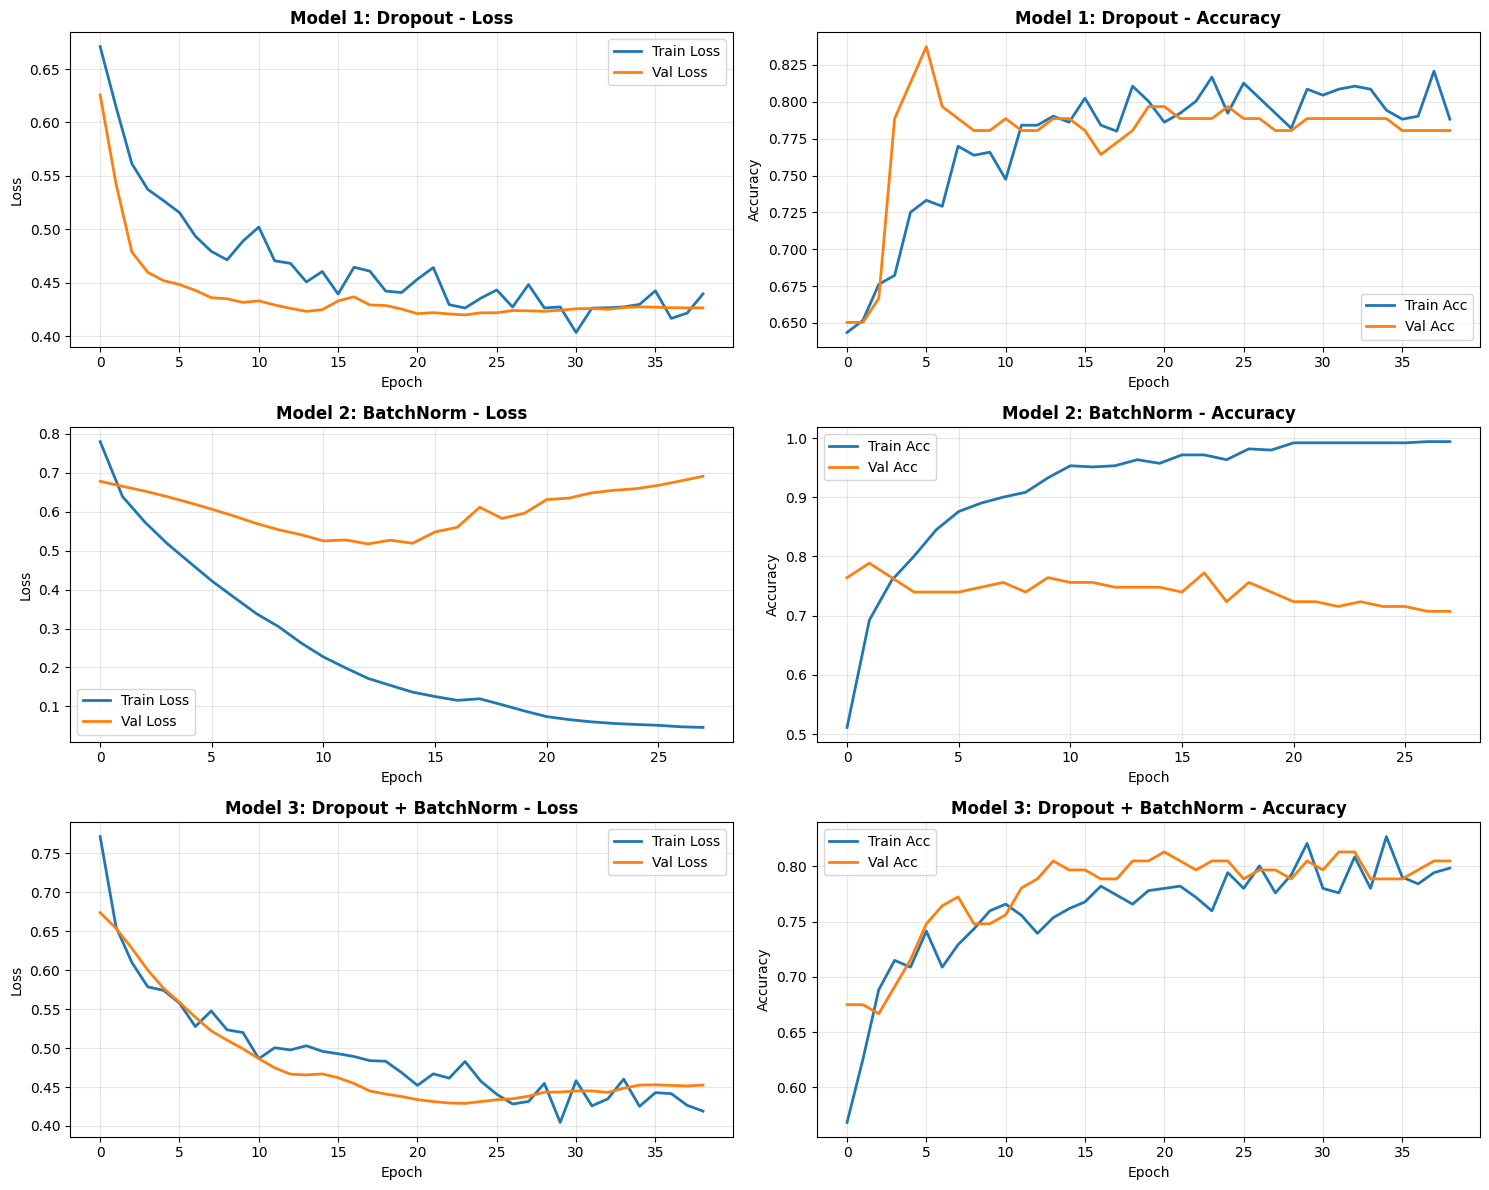

In [12]:
# Visualize training history để đánh giá overfitting
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

models_data = [
    (history_1, "Model 1: Dropout"),
    (history_2, "Model 2: BatchNorm"),
    (history_3, "Model 3: Dropout + BatchNorm")
]

for idx, (history, title) in enumerate(models_data):
    # Loss plot
    axes[idx, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[idx, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[idx, 0].set_title(f'{title} - Loss', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Epoch')
    axes[idx, 0].set_ylabel('Loss')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[idx, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
    axes[idx, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
    axes[idx, 1].set_title(f'{title} - Accuracy', fontsize=12, fontweight='bold')
    axes[idx, 1].set_xlabel('Epoch')
    axes[idx, 1].set_ylabel('Accuracy')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
#----Phan Thị Hồng Thấm - B22DCCN806-----
# Hàm đánh giá mô hình
def evaluate_model(model, X_test, y_test, history, model_name):
    # Dự đoán
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Tính các metrics
    mae = mean_absolute_error(y_test, y_pred_proba)
    mse = mean_squared_error(y_test, y_pred_proba)
    rmse = np.sqrt(mse)
    accuracy = accuracy_score(y_test, y_pred)

    # Đánh giá overfitting
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Loss gap (overfitting indicator)
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]
    loss_gap = final_val_loss - final_train_loss

    # Accuracy gap
    final_train_acc = train_acc[-1]
    final_val_acc = val_acc[-1]
    acc_gap = final_train_acc - final_val_acc

    results = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Accuracy': accuracy,
        'Train Loss': final_train_loss,
        'Val Loss': final_val_loss,
        'Loss Gap': loss_gap,
        'Train Acc': final_train_acc,
        'Val Acc': final_val_acc,
        'Acc Gap': acc_gap,
        'History': history
    }

    return results, y_pred, y_pred_proba

In [14]:
# đánh giá tất cả các mô hình
results_1, y_pred_1, y_pred_proba_1 = evaluate_model(model_1, X_test_scaled, y_test, history_1, "Model 1")
results_2, y_pred_2, y_pred_proba_2 = evaluate_model(model_2, X_test_scaled, y_test, history_2, "Model 2")
results_3, y_pred_3, y_pred_proba_3 = evaluate_model(model_3, X_test_scaled, y_test, history_3, "Model 3")

# Tạo bảng so sánh
comparison_df = pd.DataFrame([results_1, results_2, results_3])
print("\n" + "=" * 80)
print("SO SÁNH CÁC MÔ HÌNH")
print("-" * 80)
print(comparison_df[['Model', 'MAE', 'MSE', 'RMSE', 'Accuracy', 'Loss Gap', 'Acc Gap']].to_string(index=False))


SO SÁNH CÁC MÔ HÌNH
--------------------------------------------------------------------------------
  Model      MAE      MSE     RMSE  Accuracy  Loss Gap   Acc Gap
Model 1 0.303896 0.167853 0.409699  0.766234 -0.013096  0.007700
Model 2 0.368503 0.186210 0.431521  0.720779  0.645436  0.286573
Model 3 0.325139 0.173014 0.415949  0.714286  0.033489 -0.006507


In [15]:
#----Phan Thị Hồng Thấm - B22DCCN806-----

# BƯỚC KHẮC PHỤC LỖI: Gán Model 3 cho biến best_model
best_model = model_3

# Lưu mô hình và scaler
best_model.save('diabetes_model.h5')
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"\n✅ Đã lưu mô hình tốt nhất (Model 3) vào: diabetes_model.h5")
print(f"✅ Đã lưu scaler vào: scaler.pkl")


✅ Đã lưu mô hình tốt nhất (Model 3) vào: diabetes_model.h5
✅ Đã lưu scaler vào: scaler.pkl


In [ ]:
#--- Tạ Cao Sơn - B22DCCN445 -----
# Tạo thư mục templates và file HTML
import os

# Tạo thư mục templates
os.makedirs('templates', exist_ok=True)

# Tạo file index.html
html_code = """<!DOCTYPE html>
<html lang="vi">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Dự đoán Bệnh Tiểu Đường</title>
    <style>
        body {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            min-height: 100vh;
            padding: 20px;
        }

        .container {
            max-width: 800px;
            margin: 0 auto;
            background: white;
            border-radius: 20px;
            box-shadow: 0 10px 40px rgba(0,0,0,0.2);
            padding: 40px;
        }

        h1 {
            color: #333;
            text-align: center;
            margin-bottom: 10px;
            font-size: 2.5em;
        }

        .subtitle {
            text-align: center;
            color: #666;
            margin-bottom: 30px;
            font-size: 1.1em;
        }

        .form-group { margin-bottom: 20px; }
        label { display: block; margin-bottom: 8px; color: #333; font-weight: 600; font-size: 0.95em; }
        input[type="number"] { width: 100%; padding: 12px; border: 2px solid #e0e0e0; border-radius: 8px; font-size: 1em; transition: border-color 0.3s; }
        input[type="number"]:focus { outline: none; border-color: #667eea; }

        .form-row { display: grid; grid-template-columns: 1fr 1fr; gap: 20px; }

        button {
            width: 100%; padding: 15px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white; border: none; border-radius: 10px; font-size: 1.2em; font-weight: 600; cursor: pointer;
            transition: transform 0.2s, box-shadow 0.2s; margin-top: 20px;
        }
        button:hover { transform: translateY(-2px); box-shadow: 0 5px 20px rgba(102, 126, 234, 0.4); }
        button:active { transform: translateY(0); }

        .result { margin-top: 30px; padding: 20px; border-radius: 10px; text-align: center; display: none; }
        .result.success { background: #d4edda; border: 2px solid #28a745; color: #155724; }
        .result.danger { background: #f8d7da; border: 2px solid #dc3545; color: #721c24; }
        .result h2 { margin-bottom: 10px; }
        .probability { font-size: 2em; font-weight: bold; margin: 10px 0; }

        .info { background: #e7f3ff; border-left: 4px solid #2196f3; padding: 15px; margin-top: 20px; border-radius: 5px; }
        .info p { margin: 5px 0; color: #1976d2; }

        .loading { display: none; text-align: center; margin-top: 20px; }
        .spinner { border: 4px solid #f3f3f3; border-top: 4px solid #667eea; border-radius: 50%; width: 40px; height: 40px; animation: spin 1s linear infinite; margin: 0 auto; }
        @keyframes spin { 0% { transform: rotate(0deg); } 100% { transform: rotate(360deg); } }
    </style>
</head>
<body>
<div class="container">
    <h1>Dự đoán Bệnh Tiểu Đường</h1>
    <p class="subtitle">Nhập thông tin để nhận dự đoán từ mô hình AI</p>

    <form id="predictionForm">
        <div class="form-row">
            <div class="form-group">
                <label for="pregnancies">Số lần mang thai</label>
                <input type="number" id="pregnancies" name="pregnancies" min="0" max="20" value="0" required>
            </div>
            <div class="form-group">
                <label for="glucose">Glucose (mg/dL)</label>
                <input type="number" id="glucose" name="glucose" min="0" max="300" value="100" required>
            </div>
        </div>

        <div class="form-row">
            <div class="form-group">
                <label for="blood_pressure">Huyết áp (mm Hg)</label>
                <input type="number" id="blood_pressure" name="blood_pressure" min="0" max="150" value="70" required>
            </div>
            <div class="form-group">
                <label for="skin_thickness">Độ dày da (mm)</label>
                <input type="number" id="skin_thickness" name="skin_thickness" min="0" max="100" value="20" required>
            </div>
        </div>

        <div class="form-row">
            <div class="form-group">
                <label for="insulin">Insulin (mu U/ml)</label>
                <input type="number" id="insulin" name="insulin" min="0" max="1000" value="0" required>
            </div>
            <div class="form-group">
                <label for="bmi">BMI (Body Mass Index)</label>
                <input type="number" id="bmi" name="bmi" min="0" max="70" step="0.1" value="25.0" required>
            </div>
        </div>

        <div class="form-row">
            <div class="form-group">
                <label for="diabetes_pedigree">Diabetes Pedigree Function</label>
                <input type="number" id="diabetes_pedigree" name="diabetes_pedigree" min="0" max="3" step="0.01" value="0.5" required>
            </div>
            <div class="form-group">
                <label for="age">Tuổi</label>
                <input type="number" id="age" name="age" min="0" max="120" value="30" required>
            </div>
        </div>

        <button type="submit">Dự đoán</button>
    </form>

    <div class="loading" id="loading">
        <div class="spinner"></div>
        <p>Đang xử lý...</p>
    </div>

    <div class="result" id="result">
        <h2 id="result_title"></h2>
        <div class="probability" id="probability"></div>
    </div>

    <div class="info" id="info">
        <p><strong>Lưu ý:</strong> Đây chỉ là dự đoán dựa trên mô hình AI.</p>
        <p>Vui lòng tham khảo ý kiến bác sĩ để có chẩn đoán chính xác.</p>
    </div>

</div>

<script>
// You can add JS here to POST form to your Flask endpoint
</script>

</body>
</html>
"""

# Ghi file ra templates/index.html
with open(os.path.join('templates', 'index.html'), 'w', encoding='utf-8') as f:
    f.write(html_code)

print(f"✅ templates/index.html đã được tạo tại: {os.path.abspath('templates/index.html')}")


_IncompleteInputError: incomplete input (864427627.py, line 9)